In [1]:
# =============================================================================
# Import Libraries and functions
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
import torch
import gpytorch
import os
from botorch.models import MultiTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.kernels import ProductKernel
from tqdm import tqdm
# from botorch import fit_gpytorch_mll
import cloudpickle
from glob import glob
from scipy.special import eval_sh_legendre
from torch.optim import Adam
from gpytorch.kernels.keops import MaternKernel
from torch.optim import Adam
from gpytorch.likelihoods.gaussian_likelihood import (
    FixedNoiseGaussianLikelihood)
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy
%matplotlib inline

In [2]:
cwd = os.getcwd()
plots_folder = cwd

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]


def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data

In [3]:
dis_depth = 185
num_vertical_des_points = 438   
# num_vertical_des_points = 250   
num_cpts_w_bhs = 26   # 5 bhs + (num-5) cpts
bh_ids = [0, 1, 11, 19, 23] # for 20
num_bhs = 5

data, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        cpt_par = "Ic")

ids = [i for i in range(data.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]

data[:, [i for i in ids if i not in bh_ids]] = np.log(data[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])     
# =============================================================================
# create the train_x sets
data_cpts = data[:, cpt_ids]
y_nonnan_cpts = data_cpts.T.ravel()
y_nonnan_cpts = y_nonnan_cpts[~np.isnan(y_nonnan_cpts)]
len_nonnan_cpts = len(y_nonnan_cpts)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()




In [4]:
# Prepare cpt data

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = dtype)
rowind = 0; 
for i, dat in enumerate(data_cpts.T):
    idni = len(dat[~np.isnan(dat)])

    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][cpt_ids[i]]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][cpt_ids[i]]
    rowind +=idni
    
# Standardize Ic data

mu_Ic = np.mean(np.exp(y_nonnan_cpts))
std_Ic = np.std(np.exp(y_nonnan_cpts))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_Ic_log, std_Ic_log = pars_log(mu_Ic,std_Ic) 

In [5]:
# Prepare borehole data

data_bhs = data[:, bh_ids]
y_nonnan_bhs = data_bhs.T.ravel()
y_nonnan_bhs = y_nonnan_bhs[~np.isnan(y_nonnan_bhs)]
len_nonnan_bhs = len(y_nonnan_bhs)
train_x_bhs = torch.zeros((len_nonnan_bhs, 3), dtype = dtype)
rowind = 0;
for i, dat in enumerate(data_bhs.T):
    idni = len(dat[~np.isnan(dat)])
    idni = len(dat[~np.isnan(dat)])
    train_x_bhs[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_bhs[rowind:rowind+idni, 1] = grid[1][bh_ids[i]]
    train_x_bhs[rowind:rowind+idni, 2] = grid[2][bh_ids[i]]
    rowind +=idni

# Prepare borehole data

y = data[:, bh_ids].copy().T.ravel()
y = y[~np.isnan(y)]
y_vec = y.astype(int)
y_discrete = torch.tensor(y_vec).long()
classes = np.unique(y_vec)
num_classes = len(classes)
Y = np.zeros((len(y_vec), len(classes)))
for i, e in enumerate(y_vec):
    # print(i, e)
    Y[i, np.where(classes == e)[0]] = 1
    
# label transformation
a_eps = 0.002

s2_tilde = np.log(1.0 / (Y + a_eps) + 1)
Y_tilde = np.log(Y + a_eps) - 0.5 * s2_tilde

In [6]:
# merge the data
train_y = torch.cat([torch.tensor(Y_tilde, dtype = dtype).mT.ravel(), 
                       (torch.tensor(y_nonnan_cpts, dtype = dtype) - mu_Ic_log) / std_Ic_log], -1).to(dtype)

data_cpts_stdzd = (y_nonnan_cpts - mu_Ic_log) / std_Ic_log


mean_ytilde = np.mean(Y_tilde)
std_Y_tilde = np.std(Y_tilde)
# train_y = torch.cat([torch.tensor((Y_tilde-mean_ytilde)/std_Y_tilde).mT.ravel(), 
#                        (torch.tensor(y_nonnan_cpts) - mu_Ic_log) / std_Ic_log], -1)


data_Ic = (y_nonnan_cpts.reshape(-1, 1) - mu_Ic_log) / std_Ic_log
train_Yvar_bhs = torch.tensor(s2_tilde, dtype = dtype).mT.ravel().unsqueeze(-1)
train_Yvar_cpts = torch.ones_like(torch.tensor(data_Ic, dtype = dtype)) * 1e-5 # 0.01 or setting
# train_Yvar_cpts = torch.ones_like(torch.tensor(data_Ic)) * torch.tensor(1e-3).exp()

# Should I use the exp of the noise? Lokk again documentation
train_Yvar = torch.cat([train_Yvar_bhs, train_Yvar_cpts])

In [7]:
# create the train_x full with index 
num_tasks = num_classes+1
i_ind = torch.zeros(train_x_bhs.shape[0], num_tasks)
for i in range(num_tasks):
    i_ind[:, i] = torch.ones(train_x_bhs.shape[0]) * i
    
i_ind_cpts = torch.ones(train_x_cpts.shape[0])*int(num_classes)
# ------------------------------------------------------------------------------
# Needs to be modified according to the number of classes present in the training
# data! Depends on the vertical num points 

train_X = torch.cat([
     torch.cat([train_x_bhs, i_ind[:, 0].view(-1,1)], -1), 
     torch.cat([train_x_bhs, i_ind[:, 1].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 2].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 3].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 4].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 5].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 6].view(-1,1)], -1),
     # torch.cat([train_x_bhs, i_ind[:, 7].view(-1,1)], -1),
     # torch.cat([train_x_bhs, i_ind[:, 8].view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_cpts.view(-1,1)], -1),
 ], 0)

train_Xbhs = torch.cat([torch.cat([train_x_bhs, i_ind[:, i].view(-1,1)], -1) for i in range(num_classes)])
train_X = train_X.type(dtype=dtype)

train_Y = train_y.unsqueeze(-1).to(dtype)
train_yvar = train_Yvar.to(dtype)

In [8]:
# =============================================================================
# Trend function
# =============================================================================


num_tasks = num_classes+1
# rank = 4
drop_ids = [5,6,8,10,12,14,15,16,17,18,19]


def get_design_mat_1d(loc, deg):
    H = torch.tensor(np.array([eval_sh_legendre(n, loc) for n in range(deg)]).T, dtype = dtype)
    return H

   
class Legendre_poly(gpytorch.means.Mean):
    def __init__(self, mx, my, mz):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
            torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype, device=device)[:mz-len(drop_ids)]))
        self.mx = mx
        self.my = my
        self.mz = mz
        
    def Dmat(self, x):

        Phi11 = get_design_mat_1d(x[:,1].view(-1,1).cpu().numpy(), self.mx ).squeeze(0)
        Phi22 = get_design_mat_1d(x[:,2].view(-1,1).cpu().numpy(), self.my ).squeeze(0)
 
        Phi_h = torch.einsum('ik,il->ikl', Phi11, Phi22).squeeze(-1).to(device)
        
        Phi_v = get_design_mat_1d(x[:,0].reshape(-1,1).cpu().numpy(), self.mz).squeeze(0).to(device)
        Phi_v = Phi_v[:, [j for j in torch.arange(self.mz) if j not in drop_ids]]
        
        return torch.einsum( 'i,jk,ji -> j', self.weights, Phi_h, Phi_v ) 
    
    def forward(self, x):      
        # if self.training:
        res = self.Dmat(x)

        return res 

In [9]:
# The model

model_covar = ProductKernel(MaternKernel(nu=0.5,active_dims=torch.tensor([0])),     
                            MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2])
                        ))

# seems to work better with lower rank
model = MultiTaskGP(train_X = train_X, train_Y = train_Y, 
                                task_feature=-1,
                                covar_module = model_covar, 
                                train_Yvar = train_yvar,
                               # rank = 4
                                )
#model.mean_module =  Legendre_poly(1, 1, 20)

train_X, train_Y = train_X.contiguous(), train_Y.contiguous()

train_X, train_Y = train_X.to(device), train_Y.to(device)
train_yvar = train_yvar.to(device)
model = model.cuda()
model.likelihood = model.likelihood.to(device)

mll = ExactMarginalLogLikelihood(model.likelihood, model)
mll = mll.to(train_X)

# =============================================================================
# original settings
model.covar_module.kernels[0].lengthscale = torch.tensor([0.0271], dtype = dtype, device = device)  #ini
model.covar_module.kernels[1].lengthscale = torch.tensor([0.15], dtype = dtype, device = device)

model.likelihood.train()
model.train()



C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\botorch\models\multitask.py:163: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


MultiTaskGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ProductKernel(
    (kernels): ModuleList(
      (0-1): 2 x MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
    )
  )
  (task_covar_module): IndexKernel(
    (raw_var_constraint): Positive()
  )
)

In [ ]:
# Train the model with stochastic optimzer (Adam)

# from botorch.fit import fit_gpytorch_model
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
# fit_gpytorch_model(mll)

from torch.optim import Adam
hyperparameter_optimizer = Adam([{"params": model.parameters()}], lr=0.01)
# =============================================================================
#mll = ExactMarginalLogLikelihood(model.likelihood, model)

num_epochs = 250
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
loss_curve=[]
for i in epochs_iter:
    hyperparameter_optimizer.zero_grad()
    output = model(train_X)
    loss = -mll(output, model.train_targets)
    loss_curve.append(loss)
    epochs_iter.set_postfix(loss=loss.item(), theta=[model.covar_module.kernels[0].lengthscale.item(),
                               model.covar_module.kernels[1].lengthscale.item()], 
                            #B=model.task_covar_module.covar_factor,
                               )
    loss.backward()
    hyperparameter_optimizer.step()

In [11]:
# state_dict = torch.load('')

# model.load_state_dict(state_dict)
# train_X, train_y = train_X.to(device).contiguous(), train_y.to(device).contiguous()
# train_yvar = train_yvar.to(device).contiguous()
# model = model.to(device)
# model.likelihood = model.likelihood.to(device)

In [12]:
model.state_dict()

OrderedDict([('mean_module.raw_constant', tensor(-0.6784, device='cuda:0')),
             ('covar_module.kernels.0.raw_lengthscale',
              tensor([[-2.8982]], device='cuda:0')),
             ('covar_module.kernels.0.active_dims',
              tensor([0], device='cuda:0')),
             ('covar_module.kernels.0.raw_lengthscale_constraint.lower_bound',
              tensor(0., device='cuda:0')),
             ('covar_module.kernels.0.raw_lengthscale_constraint.upper_bound',
              tensor(inf, device='cuda:0')),
             ('covar_module.kernels.1.raw_lengthscale',
              tensor([[-1.5682]], device='cuda:0')),
             ('covar_module.kernels.1.active_dims',
              tensor([1, 2], device='cuda:0')),
             ('covar_module.kernels.1.raw_lengthscale_constraint.lower_bound',
              tensor(0., device='cuda:0')),
             ('covar_module.kernels.1.raw_lengthscale_constraint.upper_bound',
              tensor(inf, device='cuda:0')),
             (

In [13]:
print("lengthscale (m) vertical lv = {:.4f}".format(
    model.covar_module.kernels[0].lengthscale.item()*Dz))
print("appr. lengthscale horizontal lh = {:.4f}".format(
    model.covar_module.kernels[1].lengthscale.item() * 200))  # 201.2 m Dx


lengthscale (m) vertical lv = 1.4729
appr. lengthscale horizontal lh = 37.8626


In [14]:
# Predictions (at verification boreholes)
Dz = np.max(z_mat) 

x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 
nv_test = 2745 - int(1.86/0.01) + 1
nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = np.linspace(0.00, np.max(grid[0].numpy()), nv_test)
z_t = np.linspace(0.00, 1, nv_test)

x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

model.eval()
#likelihood = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1)).to(device)
model.likelihood.eval()

means = []; lower = []; upper = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            #predictions = likelihood(model(x_batch_t, output_indices=[len(classes)]))
            predictions = model.posterior(x_batch_t)
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)

            #samples_uscs = model.posterior(x_batch_t, output_indices=[i for i in range(len(classes))]).sample(torch.Size((100,)))
            samples_uscs = predictions.sample(torch.Size((400,)))
            pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]    
            #pred_samples_batched.append(pred_samples_uscs)
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))


In [16]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
#probabilities = torch.concat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)]
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()


In [17]:
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()


In [18]:
# =============================================================================
plt.rcParams.update({'font.family':'sans','font.size': 7,
                     'font.weight':'regular','mathtext.default':'regular',
                    'legend.fontsize':7}) 

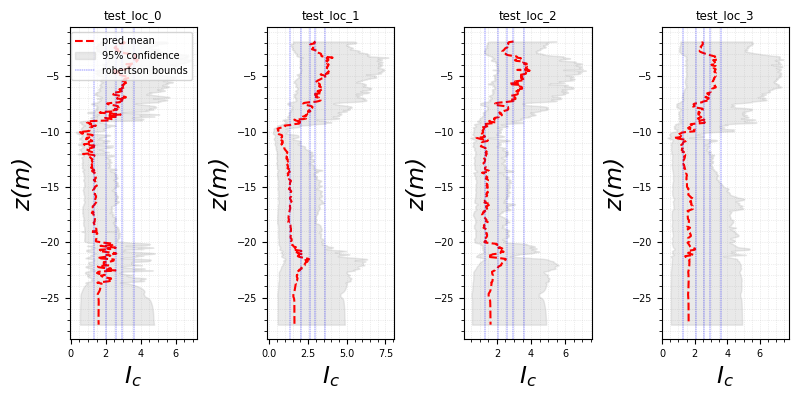

In [19]:
# =============================================================================
# Plots of Ic pred
# =============================================================================
bhs = ["bh9", "bh1", "bh5", "bh3"]
depth = z_t * (Dz-depth_0) + depth_0       
#depth = z_t * (depth_max-depth_0) + depth_0       

#depth = z_t_m 

post_mean_ic = mean[..., -1].cpu()  * std_Ic_log + mu_Ic_log         
lower_Ic = lower[..., -1].cpu() * std_Ic_log + mu_Ic_log        
upper_Ic = upper[..., -1].cpu() * std_Ic_log + mu_Ic_log      
par = "Ic"
# =============================================================================
# Plots
# =============================================================================
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
from matplotlib.ticker import AutoMinorLocator
task_names = [r'$I_c$']
fig, axs = plt.subplots(1, (x_t).shape[0], figsize=(8, 4))
for i, ax in enumerate(axs):
    cut_id = i
    ax.plot(post_mean_ic.exp().reshape(n_h, n_v).T[:, cut_id], 
            -(depth), '--',  color='red', label='pred mean')
    # Shade in confidence
    ax.fill_betweenx( -(depth), upper_Ic.exp().reshape(n_h, n_v).T[:, cut_id], 
    lower_Ic.exp().reshape(n_h, n_v).T[:, cut_id], 
    color = "darkgrey", alpha = 0.25 , label='95% confidence')     
    #ax.plot(np.exp(data[:, 4]), -(z_sc[:,4]*(Dz+depth_0)+depth_0), '-', color='blue', linewidth = 0.6, label='obs')

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
    if par == "Ic":
        for xc in bounds:
            if xc == bounds[0]:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3, label = "robertson bounds")
            else:
                ax.axvline(x=xc, linestyle = "dashed", color='blue', 
                   linewidth = 0.3)
        
    ax.grid(which="both", color="darkgrey", alpha=.4, linewidth=0.5,linestyle=":")
    plt.gca().invert_yaxis()
    ax.set_ylabel(r'$z (m)$ ', fontstyle='italic',fontsize = 17)
    ax.set_xlabel(task_names[0], fontstyle='italic',fontsize = 17)
    # ax.legend(['Observed Data', 'Mean', 'Confidence'])
    if i==0:
        ax.legend()
        # ax.set_xlim(0,3)

    ax.set_title("test_loc_"+str(i))
     # plt.gca().invert_yaxis()
#     fig.tight_layout()
#plt.savefig(plots_folder+"\\"+"VLMC_Ic_1697it_002aeps"+".png", 
#               bbox_inches='tight', dpi=400)
#plt.savefig(plots_folder+"\\"+"VLMC_Ic_1700it_5_latents_fixedind_005aeps_mll1""+.png", 
 #               bbox_inches='tight', dpi=400)
fig.tight_layout()

In [20]:
# entropy, classification metrics

inv_map = {v: k for k, v in mapping.items()}
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
depth_max = np.max(depth_points)
# depth = z_t * np.round((Dz - depth_0) + depth_0,2)       
# depth = z_t *(depth_max - depth_0) + depth_0     

N = np.array([i for i in range(num_classes)])
R = [inv_map[classes[i]] for i in N] 

def most_probable_uscs(prob, mapping, inv_map):
    num_classes = prob.shape[-1]
    max_probs = np.zeros(prob.shape[0])
    probs_np = prob.cpu().detach()
    most_prob_profile = np.zeros(prob.shape[0])
    H = np.zeros(prob.shape[0])
    for i in range(len(prob)):
        max_prob_id = np.argmax(probs_np[i].numpy())
        most_prob_profile[i] = (max_prob_id + mapping[R[0]])
        max_probs[i] = probs_np[i][max_prob_id]
        H[i] = entropy(probs_np[i].numpy(), base = 2) / entropy(np.ones(num_classes) / num_classes , base = 2)
    return most_prob_profile, max_probs, H


most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)


In [21]:
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score
import pandas as pd

# classifier
def load_data_classes(file):
    return np.array(pd.read_excel(glob("..\\Input\\"+file)[0]),dtype=str)

classes_bh_all = load_data_classes("bhs_all.xlsx")
# classes_bh_all = load_data_classes("bhs_all.xlsx")

label_encoder = LabelEncoder()
# Fit the LabelEncoder to the USCS class labels and transform them into categorical variables
encoded_classes = label_encoder.fit_transform(classes_bh_all.ravel(order="f")).reshape(classes_bh_all.shape, order = "f")
or_classes = classes_bh_all[:, [0, 2, 4, 8]]
or_classes = classes_bh_all[:, [8, 0, 4, 2]]


train_classes_bh = encoded_classes[:, [1, 3, 5, 6, 7]]
test_classes_bh = or_classes

df_test = pd.DataFrame(test_classes_bh,
                       columns = ["BH_9", "BH_1", "BH_5", "BH_3"])
z_test = z_mat[:,0]
df_test["z"] = z_test

C:\Users\ozinas\AppData\Local\Temp\ipykernel_16448\3785770170.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_16448\3785770170.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_16448\3785770170.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_16448\3785770170.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


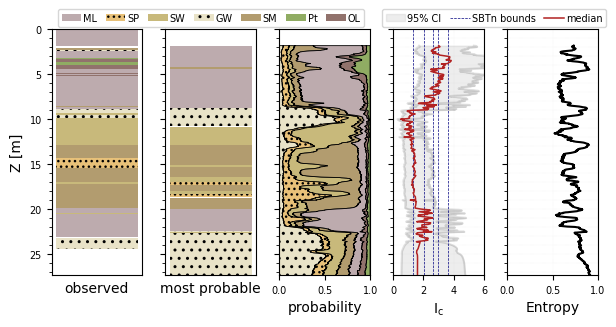

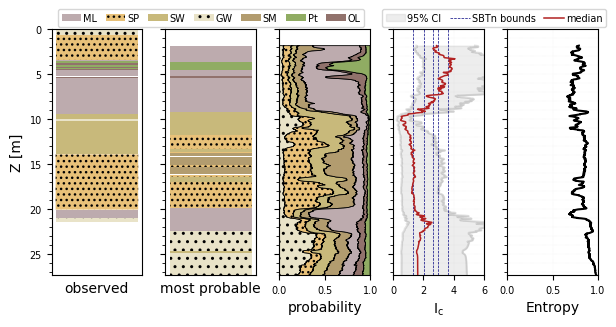

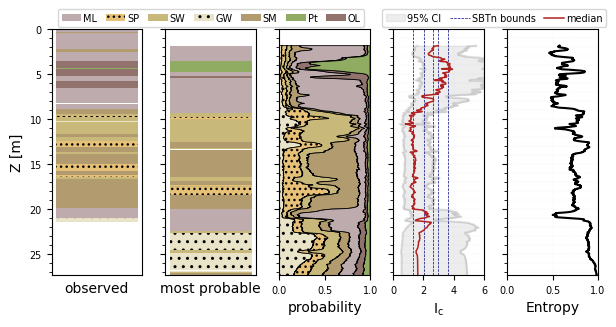

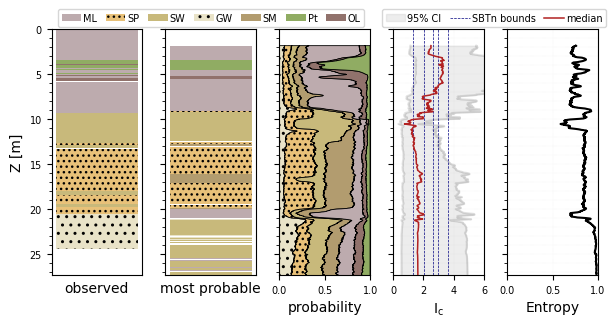

In [22]:
# =============================================================================
# Plots (1D)
# =============================================================================
from matplotlib.ticker import AutoMinorLocator

hatches=['..','...','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))
    

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

lithology_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
          (0.9090, 0.75640, 0.4750),              
          (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
          (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
          (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
          (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
          (0.5660, 0.6740, 0.3880)]


lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':lithology_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':lithology_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':lithology_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':lithology_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':lithology_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':lithology_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':lithology_colors[Rn.index("OL")]}}


# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================

                            
for loc in range(len(bhs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    #df["z"] = z_t * np.round((Dz - depth_0),2) + np.round(depth_0,2)
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    #fig = plt.figure(figsize = (15, 7))
    #fig = plt.figure(figsize = (7.05, 2.5))

    fig = plt.figure(figsize = (7.05, 3.2))
    gs = fig.add_gridspec(1, 5, hspace=0, wspace=0.255)
    (ax1, ax2, ax3, ax4, ax5) = gs.subplots(sharex='col', sharey='row')
    # fig.suptitle('Sharing x per column, y per row')
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax2.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    
    # ax1.invert_yaxis()   
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df_test["z"], 0, 1, where=(df_test.iloc[:,loc]==key),
                             facecolor=color, hatch=hatch, label=key)
        
    polys = ax3.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax3.get_xlim()
    xlims = (0, depth_max)
    ylims = ax3.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax3.set_xlim(ylims)  # use old y limits
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed
    # to plot the training data
    # for i, dat in enumerate(data_cpts.T):
    #     if i==0:  
    #         ax4.plot(np.exp(dat), (z_sc[:,i]*(Dz-1.86)+1.86), '-', 
    #                 color = "lightsteelblue", linewidth = 0.6) #, label='training data'
    #     else:
    #         ax4.plot(np.exp(dat), (z_sc[:,i]*(Dz-1.86)+1.86), '-', 
    #                 color = "lightsteelblue", linewidth = 0.6)

    ax4.plot(lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.plot(upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.fill_betweenx(df['z'], 
                      lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')# ax.set_xlim(0,5)
    # ax4.plot(np.exp(data[:,6]), np.linspace(1.86, np.max(z_mat), len(data)), '-', color='blue', linewidth = 1.1)

    for xc in bounds:
        if xc == bounds[0]:
            ax4.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
        else:
            ax4.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5)
            
    ax4.plot(post_mean_ic.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')        
    ax5.plot(H[loc], df['z'], color = "black")
    ax5.set_xlim(0,1)
    ax3.set_xlim(0,1)
    ax4.set_xlim(0,6.0)

    ax4.set_xlabel(r'$I_c$',fontsize = 10)
    ax4.legend(bbox_to_anchor=(2.4, 1.1), ncol=3, fontsize = 7, handletextpad=0.2, columnspacing=0.9)

    ax1.set_xlabel("observed",fontsize = 10)
    ax1.set_ylabel("Z [m]",fontsize = 10)
    ax2.set_xlabel("most probable",fontsize = 10)
    ax3.set_xlabel("probability",fontsize = 10)
    ax5.set_xlabel("Entropy",fontsize = 10)
    ax5.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax5.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax5.invert_yaxis() 
    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis() 
    ax2.set_xticks([])  
    ax1.set_xticks([])  
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    #ax1.legend(bbox_to_anchor=(3.25, 1.1), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)
    ax1.legend(bbox_to_anchor=(3.5, 1.1), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)


    # plt.savefig(plots_folder+"\\"+str(bhs[loc])+"variationalLMC_6lat_Ic_sbl"+".svg", 
    #            bbox_inches='tight', dpi=600)
    fig.show()    
#plt.savefig(plots_folder+"\\"+str(bhs[loc])+"variationalLMC_2000_5000ind_grid_"+str(i)+".png", bbox_inches='tight', dpi=400)
    #   
# torch.cuda.empty_cache()


# for i in range(2):
#     print(model.covar_module.base_kernel.kernels[i].lengthscale.cpu().detach() )
# model.covar_module.base_kernel.kernels[1].lengthscale 
# mode

In [23]:
encoded_classes = np.array(encoded_classes, dtype = float)
encoded_classes[encoded_classes == np.max(encoded_classes)] = np.nan


test_classes_bh_num = encoded_classes[:, [8, 0, 4, 2]]
y_test = test_classes_bh_num.T.ravel()
y_test = y_test[~np.isnan(y_test)]
y_vec_test = y_test.astype(int)
y_discrete_test = torch.tensor(y_vec_test).long()
classes_test = np.unique(y_vec_test)
num_classes = len(classes)
Y_test = np.zeros((len(y_vec_test), len(classes_test)))
#Y_pred = np.zeros((len(y_vec_test), len(classes_test)))

for i, e in enumerate(y_vec_test):
    # print(i, e)
    Y_test[i, np.where(classes_test == e)[0]] = 1
    #Y_pred[i, np.where(classes_test == e)[0]] = 1

In [24]:
def cross_entropy(targets, predictions,  epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

cross entropy skl 1.177174751396581
cross entropy manual 1.2194930964758461

accuracy score:  0.6927844178840195

precision score:  0.6423703436707748
------------------------------------
cross entropy skl 1.3989025761318488
cross entropy manual 1.4477015699641689

accuracy score:  0.6360387953037264

precision score:  0.6947640542708898
------------------------------------
cross entropy skl 1.1610290991598613
cross entropy manual 1.2098280818502534

accuracy score:  0.6171516079632465

precision score:  0.6071550888425443
------------------------------------
cross entropy skl 1.3660886995314674
cross entropy manual 1.4084070525954602

accuracy score:  0.6631252766710934

precision score:  0.7770648968556102
------------------------------------

accuracy score total:  0.6541014698909435

precision score total:  0.6655219471135985
cross entropy skl total 1.2755024048770651


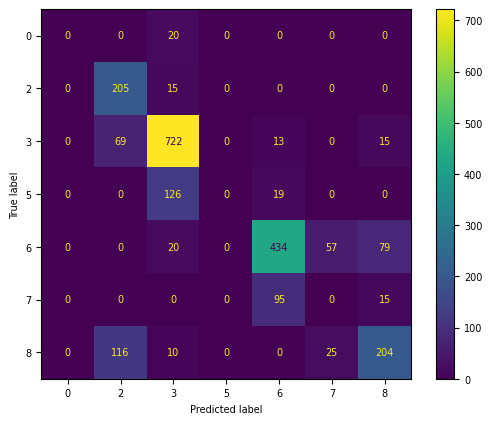

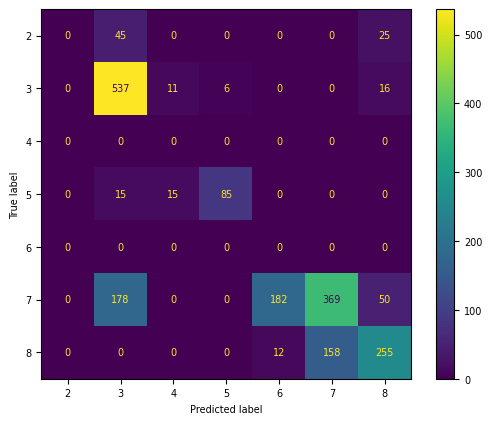

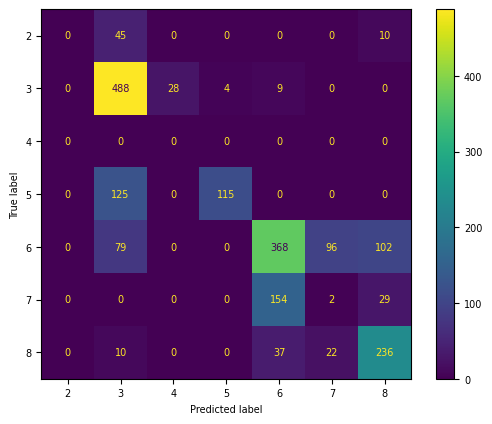

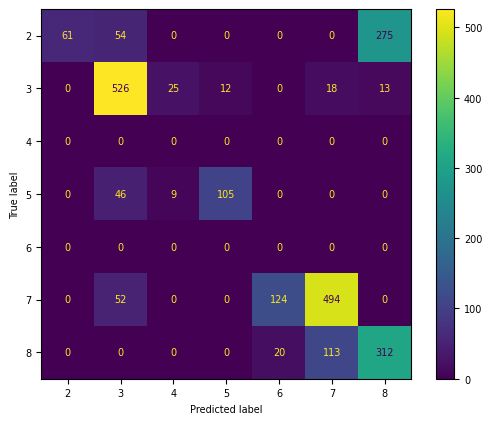

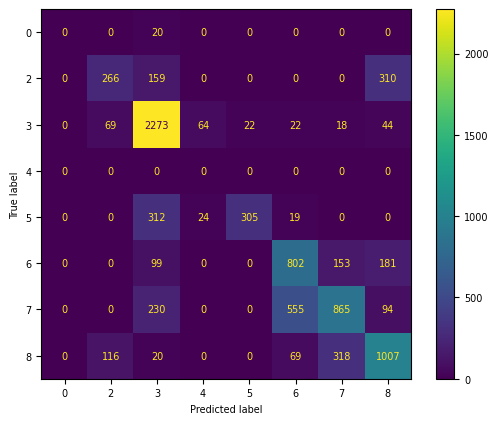

In [25]:
#### The number of nonnan elements in each testing borehole
bhi_test_num_el = (np.ones(4)*len(encoded_classes) - np.isnan(encoded_classes[:, [8, 0, 4, 2]]).sum(axis=0)).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, log_loss



from collections import defaultdict
dict_metrics_bh = {i: defaultdict(list) for i in range(len(bhs))}

y_true=[]; y_pred=[]; targets = []; inputs = []#to test entire set of bhs
for loc in range(len(bhs)):   

    # dict_metrics_bh["z_bh"].append(df_test["z"][:bhi_test_num_el[loc]])
    # dict_metrics_bh["y_test_bh"].append( torch.tensor(Y_test[:bhi_test_num_el[bh_loc], :][np.where(z_bh9>=1.86)] ))
    z_bh = df_test["z"][:bhi_test_num_el[loc]]
    dict_metrics_bh[loc]["z_bh"]=(df_test["z"][:bhi_test_num_el[loc]])
    dict_metrics_bh[loc]["y_test_bh"]=( torch.tensor(Y_test[:bhi_test_num_el[loc], :][np.where(z_bh>=1.86)] ))

   # y_test_cat_bh[y_test_cat_bh==5] = 4
    dict_metrics_bh[loc]["y_test_bh_cat"]=np.array(encoded_classes[:, [8, 0, 4, 2]][np.where(z_bh>=1.86)] [:, loc], dtype=int)
   
#     #===========================================
#     #merge OL and Pt
    dict_metrics_bh[loc]["y_test_bh_cat"][dict_metrics_bh[loc]["y_test_bh_cat"]==4] = 5
#     #===========================================
    pred_probs_bh =  probabilities[loc][np.where(depth<=max(z_bh))]
    z_bh = z_bh[z_bh>=1.86]

    #dict_metrics_bh[loc]["pred_probs_bh"] = probabilities[loc][np.where(depth<=max(z_bh))]
    pred_probs_bh = torch.cat([torch.zeros(len(pred_probs_bh), 2), pred_probs_bh], -1).clone().detach().requires_grad_(True)
    pred_class = np.array(most_prob_profile[loc][np.where(depth<=max(z_bh))],dtype=int)
    dict_metrics_bh[loc]["pred_probs_bh"] = pred_probs_bh
    dict_metrics_bh[loc]["pred_class_bh"] = pred_class

    loss = torch.nn.CrossEntropyLoss()
    input = dict_metrics_bh[loc]["pred_probs_bh"]
    target = dict_metrics_bh[loc]["y_test_bh"]
    # output = loss(input, target)
    # output.backward()
    
    # print("test_loc", loc)
    # # print("cross entropy", output.item())

    targets.append(target.numpy()); inputs.append(input.detach())
    print("cross entropy skl", log_loss( target.numpy(), input.detach().numpy()))
    print("cross entropy manual", cross_entropy( target.numpy(), input.detach().numpy()))
    
    print("\naccuracy score: ",  accuracy_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"]))
    
    print("\nprecision score: ",  precision_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"], average = "weighted", zero_division = 0.0 ))
    
    ConfusionMatrixDisplay.from_predictions(dict_metrics_bh[loc]["y_test_bh_cat"],
                                            dict_metrics_bh[loc]["pred_class_bh"],
                                           #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                           )
    
    print("------------------------------------")
    y_true.append(dict_metrics_bh[loc]["y_test_bh_cat"])
    y_pred.append(dict_metrics_bh[loc]["pred_class_bh"])


    
print("\naccuracy score total: ",  accuracy_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred)
                                                  ))
print("\nprecision score total: ",  precision_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred), 
                                                  average = "weighted", zero_division = 0.0 ))
print("cross entropy skl total", log_loss( np.concatenate(targets), np.concatenate(inputs)))

ConfusionMatrixDisplay.from_predictions(np.concatenate(y_true),
                                        np.concatenate(y_pred),
                                        #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                        )
